# Tweet Sentiment Extraction概要<br>URL：https://www.kaggle.com/c/tweet-sentiment-extraction
<b>最終提出期限：2020/6/17</b><br><br>

ツイートに対し「neutral」「positive」「negative」のラベル付けがされており、<bR>そのラベル付けの根拠となる単語や文を推定するコンペです。

コンペ期間中はテストデータの30%に対するスコアがPublic Leaderboardに掲載され、<br>
最終評価は残りの70%のテストデータに対するスコアでPrivate Leaderboardに順位付けされます。<br><br>

また、このコンペはノートブックコンペです。<br>
成果物は「submission.csv」だけではなく、ノートブック自体も含まれます。<br>
コミット後に[Submit to Competition]ボタンをアクティブにするには、次の条件を満たす必要があります。
* CPUカーネル 残時間3時間以上のランタイム
* GPUカーネル 残時間3時間以上のランタイム
* TPUは使用禁止
* インターネットアクセスは無効
* 事前トレーニング済みのモデルを含む、公開外部データは使用可能
<br>
評価指標はジャッカード係数です。
参考：https://analytics-note.xyz/statistics/jaccard-index/

### 社内向けメモ
事前トレーニングモデルの使用も認められているため、<br>ローカルPCやGoogle Golaboratoryでモデル訓練を実施し、<br>推論を実施するノートブックをKaggle Notebook上に用意するのが良いかと思います。<br>このノートブックではGoogle Colaboratory上での訓練方法を記載します。

# 解法案
一例として以下のような解法があると思います。<br>

入力文字列をクリーニング(ストップワード削除、固有名称置き換え、スペル校正等)を行った上で、<br>
① 自然言語処理モデル(BERT、XLNet、RoBERTa、T5など)に入力し特徴ベクトルを得る<br>
② 特徴ベクトルを入力として、抽出文の開始位置と終了位置を出力する<br><br>
※別途議論されていますが、今回の学習データ/テストデータ共に、<br>スペルミスやネット特有の表現、アノテーションミスが多々あり、<br>クリーニングせずにデータ拡張だけを行ったほうが精度が良い可能性があります。

![model_example](https://user-images.githubusercontent.com/37477845/83969820-0d3d1f80-a90d-11ea-9a83-dd9b402d87b5.jpg)

# Google Colaboratory用：GPU残時間

In [0]:
!cat /proc/uptime | awk '{print 0.5 - ($1 /60 /60 /24)" days (" 12 - ($1 / 60 / 60) " h)"}'

0.497983 days (11.9516 h)


# Kaggle API準備
Kaggleのユーザーアカウントページ (https://www.kaggle.com/********/account) にて<br>「Create New API Token」を押下し、kaggle.jsonをダウンロードする。

In [0]:
# kaggle.jsonをアップロードする
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
!pip install kaggle

# Google Drive準備
※訓練モデル格納用

In [0]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


# コンペデータ ダウンロード

In [0]:
COMPETITION_NAME='tweet-sentiment-extraction'

In [0]:
!kaggle competitions download -c $COMPETITION_NAME

  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 35.7MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 81.0MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 101MB/s]


In [0]:
!unzip train.csv.zip
!mkdir ../input
!mkdir ../input/tweet-sentiment-extraction
!mv test.csv ../input/tweet-sentiment-extraction
!mv train.csv ../input/tweet-sentiment-extraction
!mv sample_submission.csv ../input/tweet-sentiment-extraction
!rm train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


# Tensorflow2向け RoBERTa学習済みモデル ダウンロード

In [0]:
!kaggle datasets download -d cdeotte/tf-roberta

 99% 287M/290M [00:01<00:00, 185MB/s]
100% 290M/290M [00:01<00:00, 169MB/s]


In [0]:
!unzip tf-roberta.zip
!mkdir ../input/tf-roberta
!mv config-roberta-base.json ../input/tf-roberta
!mv vocab-roberta-base.json ../input/tf-roberta
!mv merges-roberta-base.txt ../input/tf-roberta
!mv pretrained-roberta-base.h5 ../input/tf-roberta
!rm tf-roberta.zip

Archive:  tf-roberta.zip
  inflating: config-roberta-base.json  
  inflating: merges-roberta-base.txt  
  inflating: pretrained-roberta-base.h5  
  inflating: vocab-roberta-base.json  


# Google Colaboratory用：必要ライブラリインストール

In [0]:
!pip install transformers
!pip install tensorflow==2.1.0

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 890kB 13.7MB/s 
     |████████████████████████████████| 1.1MB 17.3MB/s 
     |████████████████████████████████| 3.8MB 23.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a9ef7e619258fb4a5b18b61f77fe50b79bc9a3591c66d2a5ec98deaf5c8ba4df
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 421.8MB 23kB/s 
     |████████████████████████████████| 450kB 44.6MB/s 
     |████████████████████████████████| 3.9MB 49.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d452f3a9cf9513ee69cd00602612b446328f68cc9a963727626d736f283a6ef8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10

# データ読み込み

In [0]:
import pandas as pd

def read_train():
    train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
    train['text'] = train['text'].astype(str)
    train['selected_text'] = train['selected_text'].astype(str)
    return train

def read_test():
    test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')
    test['text'] = test['text'].astype(str)
    return test

def read_submission():
    submission = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')
    return submission

In [0]:
train_df = read_train()

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27481 non-null  object
 2   selected_text  27481 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [0]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [0]:
test_df = read_test()

In [0]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [0]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [0]:
submission_df = read_submission()

In [0]:
submission_df.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


# EDA（探索的データ解析）
以下を参考にしています。
* https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

# データクリーニング・データ拡張・特徴量追加

In [0]:
# ToDo：データクリーニング

In [0]:
# ToDo：データ拡張

In [0]:
# ToDo：特徴量エンジニアリング

# モデル訓練

In [0]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

TF version 2.1.0


In [0]:
# 評価指標：ジャッカード係数
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
# BERTトークナイザー準備
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

In [0]:
# 各種設定値
MAX_LEN = 128
EPOCHS = 3
BATCH_SIZE = 32
PAD_ID = 1
SEED = 42
LABEL_SMOOTHING = 0.1

sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [0]:
# 乱数シード初期化
def random_seed_initialize(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    tf.random.set_seed(seed)

random_seed_initialize(SEED)

In [0]:
# BERTインプット準備
input_ids = np.ones((train_df.shape[0], MAX_LEN), dtype='int32')
attention_mask = np.zeros((train_df.shape[0] ,MAX_LEN), dtype='int32')
token_type_ids = np.zeros((train_df.shape[0], MAX_LEN), dtype='int32')
start_tokens = np.zeros((train_df.shape[0], MAX_LEN), dtype='int32')
end_tokens = np.zeros((train_df.shape[0], MAX_LEN), dtype='int32')

In [0]:
# 学習データ：インプット準備
for k in range(train_df.shape[0]):
    # selected_textの箇所を抽出
    text1 = " "+" ".join(train_df.loc[k,'text'].split())
    text2 = " ".join(train_df.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # IDオフセット
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # 開始/終了トークンを設定
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train_df.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask[k,:len(enc.ids)+3] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

In [0]:
# テストデータ：インプット準備
input_ids_t = np.ones((test_df.shape[0],MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((test_df.shape[0],MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((test_df.shape[0],MAX_LEN),dtype='int32')

for k in range(test_df.shape[0]):
    # インプットID
    text1 = " "+" ".join(test_df.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test_df.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    attention_mask_t[k,:len(enc.ids)+3] = 1

In [0]:
# モデル(RoBERTa＋全結合(2出力))
import pickle

def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)


def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model

def loss_fn(y_true, y_pred):
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss


def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN - tf.reduce_sum(padding, -1)
    max_len = tf.reduce_max(lens)
    ids_ = ids[:, :max_len]
    att_ = att[:, :max_len]
    tok_ = tok[:, :max_len]

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids_,attention_mask=att_,token_type_ids=tok_)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
    model.compile(loss=loss_fn, optimizer=optimizer)
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN - max_len]], constant_values=0.)
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])

    return model, padded_model

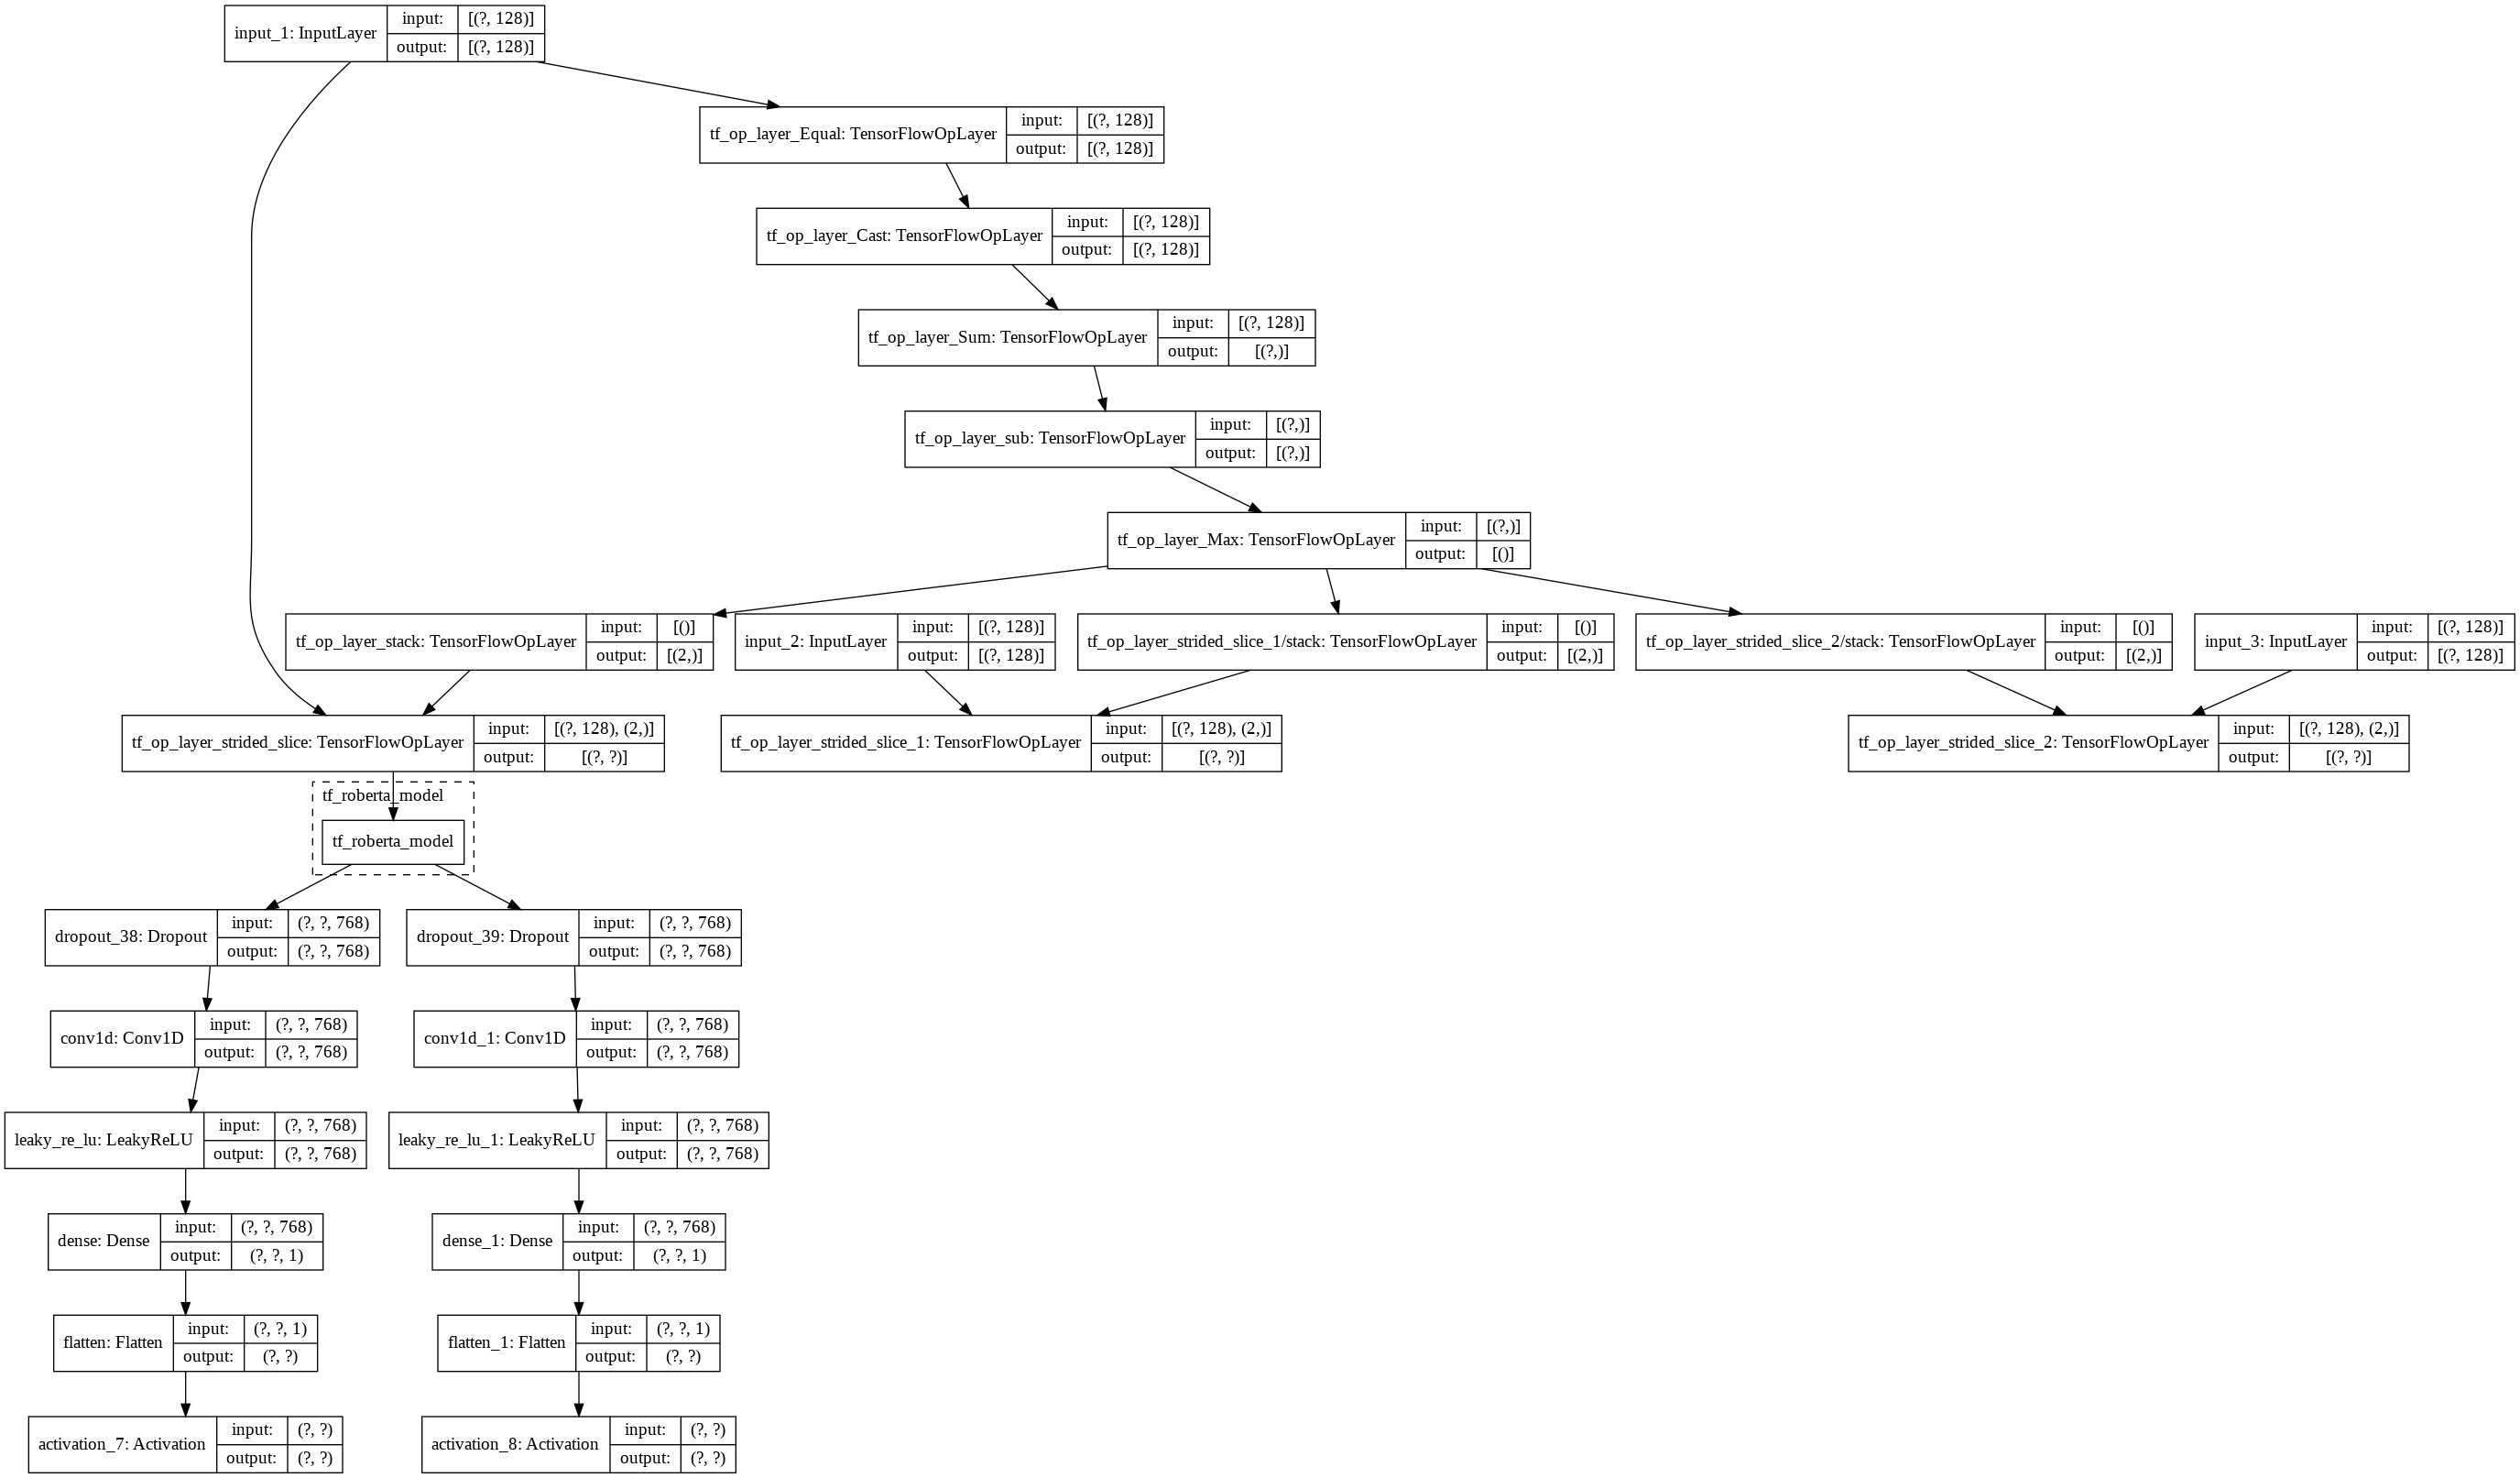

In [0]:
# モデル構造確認
model, padded_model = build_model()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [0]:
n_splits = 5

In [0]:
import math

jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=SEED) #originally 5 splits
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train_df.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
        
    #sv = tf.keras.callbacks.ModelCheckpoint(
    #    '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
    #    save_weights_only=True, mode='auto', save_freq='epoch')
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    weight_fn = '%s-roberta-%i.h5'%(VER,fold)
    for epoch in range(1, EPOCHS + 1):
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, callbacks=[],
            validation_data=(inpV, targetV), shuffle=False)  # don't shuffle in `fit`
        save_weights(model, weight_fn)

    print('Loading model...')
    # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    load_weights(model, weight_fn)

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = padded_model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train_df.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train_df.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        all.append(jaccard(st,train_df.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

In [0]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

In [0]:
print(jac) # Jaccard CVs

In [0]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test_df.loc[k,'text']
    else:
        text1 = " "+" ".join(test_df.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-2:b-1])
    all.append(st)

# 推論

In [0]:
preds_start = np.zeros((input_ids_t.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0], MAX_LEN))
DISPLAY=1
for i in range(n_splits):
    print('#'*25)
    print('### MODEL %i'%(i+1))
    print('#'*25)
    
    K.clear_session()
    model, padded_model = build_model()
    file_name = '%s-roberta-%i.h5'%(VER,i)
    print(file_name)
    model = load_weights(padded_model, file_name) # model.load_weights(file_name)

    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/n_splits
    preds_end += preds[1]/n_splits

In [0]:
test_df['selected_text'] = all
test_df[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test_df.sample(25)

In [0]:
# 学習モデル保存
!mv v0-roberta-0.h5 './gdrive/My Drive/Kaggle/01.Tweet Sentiment Extraction'
!mv v0-roberta-1.h5 './gdrive/My Drive/Kaggle/01.Tweet Sentiment Extraction'
!mv v0-roberta-2.h5 './gdrive/My Drive/Kaggle/01.Tweet Sentiment Extraction'
!mv v0-roberta-3.h5 './gdrive/My Drive/Kaggle/01.Tweet Sentiment Extraction'
!mv v0-roberta-4.h5 './gdrive/My Drive/Kaggle/01.Tweet Sentiment Extraction'

# データ提出

In [0]:
# 今回のコンペはコードコンペのためsubmissionファイルのみの提出は不可
# !kaggle competitions submit $COMPETITION_NAME -f submission.csv -m "Google Colaboratory"